# Linear models for classification with a logistic regression

In regression, we saw that the target to be predicted is a continuous
variable. In classification, the target is discrete (e.g. categorical).

In this notebook we go back to the penguin dataset. However, this time the
task is to predict the penguin species using the culmen information. We also
simplify our classification problem by selecting only 2 of the penguin species
to solve a binary classification problem.

In [1]:
import pandas as pd

penguins = pd.read_csv("penguins_classification.csv")

penguins

,Culmen Length (mm),Culmen Depth (mm),Species
0,39.1,18.7,Adelie
1,39.5,17.4,Adelie
2,40.3,18.0,Adelie
3,36.7,19.3,Adelie
4,39.3,20.6,Adelie
...,...,...,...
337,55.8,19.8,Chinstrap
338,43.5,18.1,Chinstrap
339,49.6,18.2,Chinstrap
340,50.8,19.0,Chinstrap


In [2]:
# only keep the Adelie and Chinstrap classes
penguins = (
    penguins.set_index("Species").loc[["Adelie", "Chinstrap"]].reset_index()
)
culmen_columns = ["Culmen Length (mm)", "Culmen Depth (mm)"]
target_column = "Species"

In [3]:
penguins

,Species,Culmen Length (mm),Culmen Depth (mm)
0,Adelie,39.1,18.7
1,Adelie,39.5,17.4
2,Adelie,40.3,18.0
3,Adelie,36.7,19.3
4,Adelie,39.3,20.6
...,...,...,...
214,Chinstrap,55.8,19.8
215,Chinstrap,43.5,18.1
216,Chinstrap,49.6,18.2
217,Chinstrap,50.8,19.0


We can quickly start by visualizing the feature distribution by class:

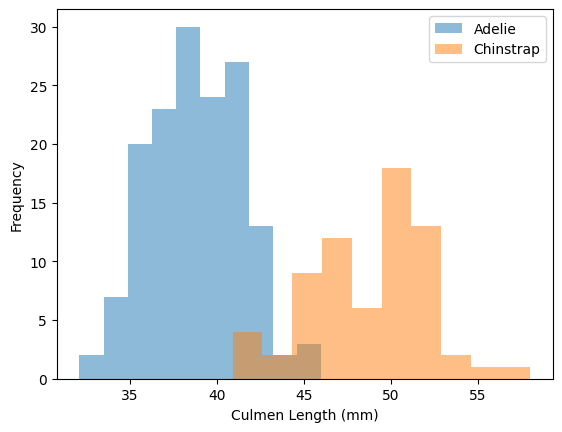

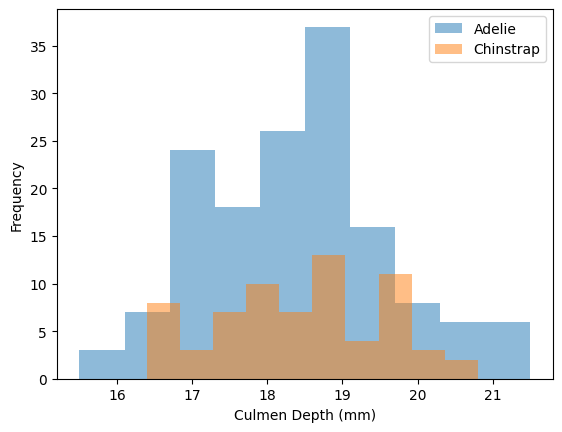

In [4]:
import matplotlib.pyplot as plt

for feature_name in culmen_columns:
    plt.figure()
    # plot the histogram for each specie
    penguins.groupby("Species")[feature_name].plot.hist(alpha=0.5, legend=True)
    plt.xlabel(feature_name)

We can observe that we have quite a simple problem. When the culmen length
increases, the probability that the penguin is a Chinstrap is closer to 1.
However, the culmen depth is not helpful for predicting the penguin species.

For model fitting, we separate the target from the data and we create a
training and a testing set.

In [5]:
from sklearn.model_selection import train_test_split

penguins_train, penguins_test = train_test_split(penguins, random_state=0)

data_train = penguins_train[culmen_columns]
data_test = penguins_test[culmen_columns]

target_train = penguins_train[target_column]
target_test = penguins_test[target_column]

The linear regression that we previously saw predicts a continuous output.
When the target is a binary outcome, one can use the logistic function to
model the probability. This model is known as logistic regression.

Scikit-learn provides the class `LogisticRegression` which implements this
algorithm.

In [6]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

logistic_regression = make_pipeline(StandardScaler(), LogisticRegression())
logistic_regression.fit(data_train, target_train)
accuracy = logistic_regression.score(data_test, target_test)
print(f"Accuracy on test set: {accuracy:.3f}")

Accuracy on test set: 1.000


Since we are dealing with a classification problem containing only 2 features,
it is then possible to observe the decision function boundary. The boundary is
the rule used by our predictive model to affect a class label given the
feature values of the sample.

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p>Here, we use the class <tt class="docutils literal">DecisionBoundaryDisplay</tt>. This educational tool allows
us to gain some insights by plotting the decision function boundary learned by
the classifier in a 2 dimensional feature space.</p>
<p class="last">Notice however that in more realistic machine learning contexts, one would
typically fit on more than two features at once and therefore it would not be
possible to display such a visualization of the decision boundary in
general.</p>
</div>

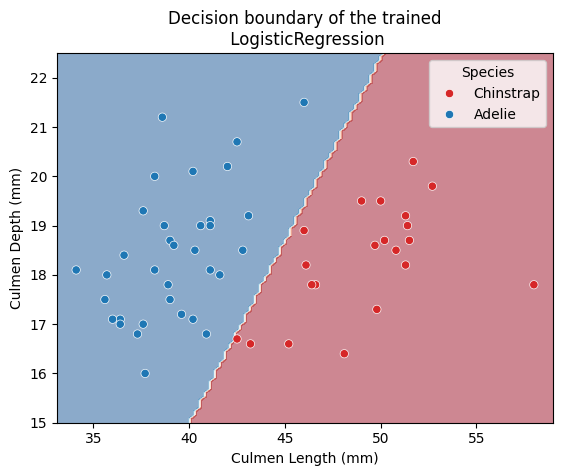

In [7]:
import seaborn as sns
from sklearn.inspection import DecisionBoundaryDisplay

DecisionBoundaryDisplay.from_estimator(
    logistic_regression,
    data_test,
    response_method="predict",
    cmap="RdBu_r",
    alpha=0.5,
)
sns.scatterplot(
    data=penguins_test,
    x=culmen_columns[0],
    y=culmen_columns[1],
    hue=target_column,
    palette=["tab:red", "tab:blue"],
)
_ = plt.title("Decision boundary of the trained\n LogisticRegression")

Thus, we see that our decision function is represented by a straight line
separating the 2 classes.

For the mathematically inclined reader, the equation of the decision boundary
is:

    coef0 * x0 + coef1 * x1 + intercept = 0

where `x0` is `"Culmen Length (mm)"` and `x1` is `"Culmen Depth (mm)"`.

This equation is equivalent to (assuming that `coef1` is non-zero):

    x1 = coef0 / coef1 * x0 - intercept / coef1

which is the equation of a straight line.

Since the line is oblique, it means that both coefficients (also called
weights) are non-null:

In [8]:
coefs = logistic_regression[-1].coef_[0]
weights = pd.Series(coefs, index=[f"Weight for '{c}'" for c in culmen_columns])
weights

Weight for 'Culmen Length (mm)'    3.724791
Weight for 'Culmen Depth (mm)'    -1.096371
dtype: float64

You can [access pipeline
steps](https://scikit-learn.org/stable/modules/compose.html#access-pipeline-steps)
by name or position. In the code above `logistic_regression[-1]` means the
last step of the pipeline. Then you can access the attributes of that step such
as `coef_`. Notice also that the `coef_` attribute is an array of shape (1,
`n_features`) an then we access it via its first entry. Alternatively one
could use `coef_.ravel()`.

We are now ready to visualize the weight values as a barplot:

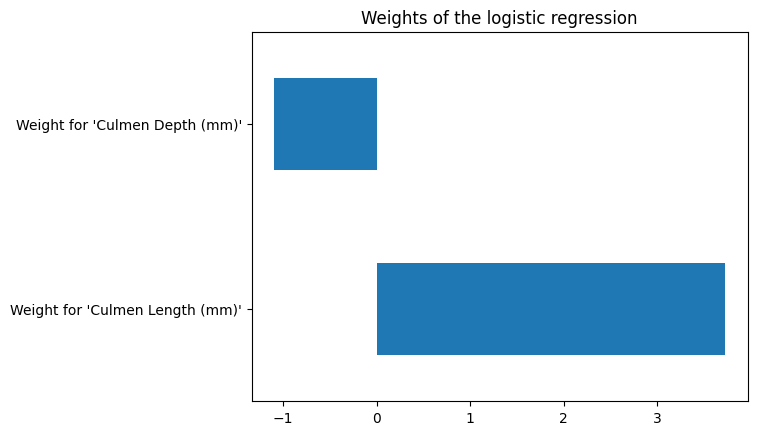

In [9]:
weights.plot.barh()
_ = plt.title("Weights of the logistic regression")

If one of the weights had been zero, the decision boundary would have been
either horizontal or vertical.

Furthermore the intercept is also non-zero, which means that the decision does
not go through the point with (0, 0) coordinates.

## (Estimated) predicted probabilities

The `predict` method in classification models returns what we call a "hard
class prediction", i.e. the most likely class a given data point would belong
to. We can confirm the intuition given by the `DecisionBoundaryDisplay` by
testing on a hypothetical `sample`:

In [11]:
test_penguin = pd.DataFrame(
    {"Culmen Length (mm)": [45], "Culmen Depth (mm)": [17]}
)
logistic_regression.predict(test_penguin)

array(['Chinstrap'], dtype=object)

In this case, our logistic regression classifier predicts the Chinstrap
species. Note that this agrees with the decision boundary plot above: the
coordinates of this test data point match a location close to the decision
boundary, in the red region.

As mentioned in the introductory slides 🎥 **Intuitions on linear models**,
one can alternatively use the `predict_proba` method to compute continuous
values ("soft predictions") that correspond to an estimation of the confidence
of the target belonging to each class.

For a binary classification scenario, the logistic regression makes both hard
and soft predictions based on the [logistic
function](https://en.wikipedia.org/wiki/Logistic_function) (also called
sigmoid function), which is S-shaped and maps any input into a value between 0
and 1.

In [12]:
y_pred_proba = logistic_regression.predict_proba(test_penguin)
y_pred_proba

array([[0.1714923, 0.8285077]])

More in general, the output of `predict_proba` is an array of shape
(`n_samples`, `n_classes`)

In [13]:
y_pred_proba.shape

(1, 2)

Also notice that the sum of (estimated) predicted probabilities across classes
is 1.0 for each given sample. We can visualize them for our `test_penguin` as
follows:

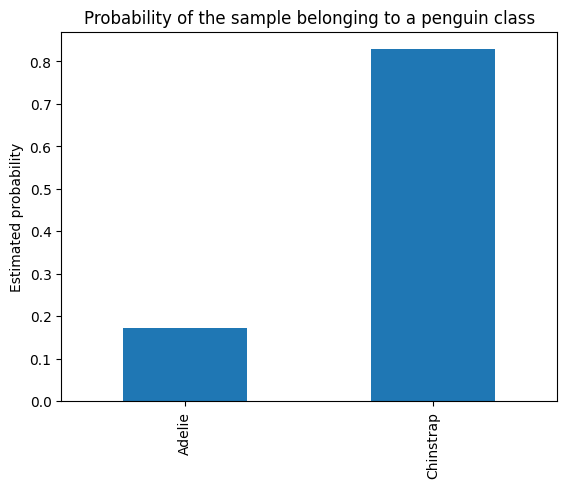

In [14]:
y_proba_sample = pd.Series(
    y_pred_proba.ravel(), index=logistic_regression.classes_
)
y_proba_sample.plot.bar()
plt.ylabel("Estimated probability")
_ = plt.title("Probability of the sample belonging to a penguin class")

<div class="admonition warning alert alert-danger">
<p class="first admonition-title" style="font-weight: bold;">Warning</p>
<p class="last">We insist that the output of <tt class="docutils literal">predict_proba</tt> are just estimations. Their
reliability on being a good estimate of the true conditional class-assignment
probabilities depends on the quality of the model. Even classifiers with a
high accuracy on a test set may be overconfident for some individuals and
underconfident for others.</p>
</div>

Similarly to the hard decision boundary shown above, one can set the
`response_method` to `"predict_proba"` in the `DecisionBoundaryDisplay` to
rather show the confidence on individual classifications. In such case the
boundaries encode the estimated probablities by color. In particular, when
using [matplotlib diverging
colormaps](https://matplotlib.org/stable/users/explain/colors/colormaps.html#diverging)
such as `"RdBu_r"`, the softer the color, the more unsure about which class to
choose (the probability of 0.5 is mapped to white color).

Equivalently, towards the tails of the curve the sigmoid function approaches
its asymptotic values of 0 or 1, which are mapped to darker colors. Indeed,
the closer the predicted probability is to 0 or 1, the more confident the
classifier is in its predictions.

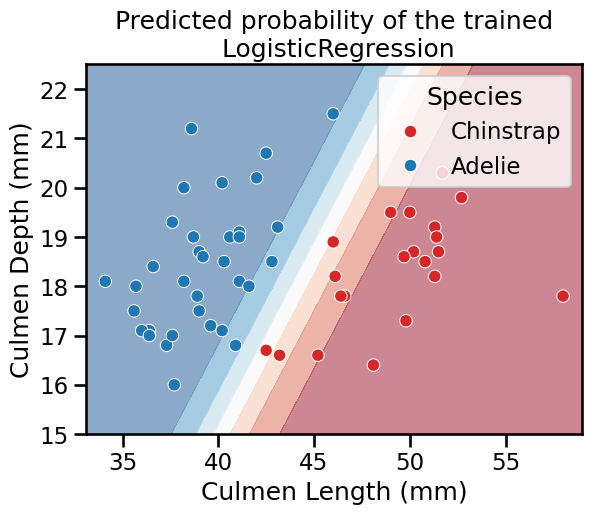

In [17]:
DecisionBoundaryDisplay.from_estimator(
    logistic_regression,
    data_test,
    response_method="predict_proba",
    cmap="RdBu_r",
    alpha=0.5,
)
sns.scatterplot(
    data=penguins_test,
    x=culmen_columns[0],
    y=culmen_columns[1],
    hue=target_column,
    palette=["tab:red", "tab:blue"],
)
_ = plt.title("Predicted probability of the trained\n LogisticRegression")

For multi-class classification the logistic regression uses the [softmax
function](https://en.wikipedia.org/wiki/Softmax_function) to make predictions.
Giving more details on that scenario is beyond the scope of this MOOC.

In any case, interested users are refered to the [scikit-learn user guide](
https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)
for a more mathematical description of the `predict_proba` method of the
`LogisticRegression` and the respective normalization functions.